## Unsupervised Player Classifier

In cricket there are several roles which players can take. The most broad of these roles are bowlers and batsmen. A batsman is a player who specialises at scoring runs, while a bowlers specialise at bowling at batsmen. A third position is wicket keeper. Every team has a wicket keeper which is a specialized fielding position. These players are also typically considered batsmen. The dataset that is available from cricksheet does not attribute wickets that have been caught behind or stumped to a player, and therefore it seems unlikely that wicket keepers can be readily identified.

Aside from these three positions there are also all rounders. These players are adept at both bowling and batting.

In this project I am to create a classifier which can seperate players into different classes based on their bowling and batting performance. The dataset does not contain labels for player type, so this classification must be performed in an unsupervised manner.

The project consists of the following sections.
    1. Data Exploration and Processing.
    2. Data selection.
    3. Clustering
        3.1 Kmeans clustering
        3.2 Visualizing clustering on data
        3.3 TSNE dimensionality reduction
        3.4 Hierarchical clustering
    4. Samples of Australian players
    5. Summary

## 1. Data Exploration and Processing

There are two CSV files which store information on player statistics. These are the 'batting_stats' and 'bowling_stats' files. These files along with basic libraries are loaded below.

In [1]:
#load libraries

%matplotlib inline
import matplotlib

#basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

import random

sns.set(style="whitegrid")


#read in data sets

match_information = pd.read_csv(r'processed_data/match_information.csv')
batting_stats = pd.read_csv(r'processed_data/batting_stats.csv')
bowling_stats = pd.read_csv(r'processed_data/bowling_stats.csv')

### Data processing

In [141]:
# get a subset of the columns in batting_stats relevent to a players performance
batting = batting_stats[['match_id','innings','batsman','batting_team','runs','balls_faced','out','zeros','ones','twos','threes','fours','fives','sixes']]

# get a subset of the columns in bowling_stats relevent to a players performance
bowling = bowling_stats[['match_id','innings','bowler','bowling_team','deliveries','wickets','runs']]

# rename columns in bowling so that they do not conflict with columns in batting
bowling.rename(columns={'runs':'runs_conceded'}, inplace=True)


# join the batting and bowling dataframes on player, match and innings
player = pd.merge(batting, bowling, how='outer', left_on = ['match_id','innings','batsman'], right_on = ['match_id','innings','bowler'])


#create a player column and remove batsmen and bowler columns
player['batsman'].fillna(player['bowler'], inplace=True)
player['bowler'].fillna(player['batsman'], inplace=True)
player.drop('bowler', axis=1, inplace=True)
player.rename(columns={'batsman': 'player'}, inplace=True)

#similarly create a team column and remove batting_team and bowling_team
player['batting_team'].fillna(player['bowling_team'], inplace=True)
player['bowling_team'].fillna(player['batting_team'], inplace=True)
player.drop('bowling_team', axis=1, inplace=True)
player.rename(columns={'batting_team':'team'}, inplace=True)

#fill remaining entries with 0's
#this fills out bowling stats for players who have not bowled, or less frequently
#players who have not batted.
player.fillna(0, inplace=True)

#aggregate over player, match_id and team

player['out'] = player['out'].astype('int')
player = player.groupby(['match_id','player','team']).sum()
player.drop('innings', axis=1, inplace=True)
player.reset_index(inplace=True)



#Now I want to calculate on a match by match basis how many deliveries are bowled by a team.
#This is useful because it allows me to calculate what fraction of deliveries a player bowls
#for a team.

match_deliveries = bowling_stats[['match_id','deliveries','bowling_team']].groupby(['match_id','bowling_team']).sum()
match_deliveries.reset_index(inplace=True)
match_deliveries.rename(columns={'deliveries':'match_deliv', 'bowling_team':'team'}, inplace=True)


#merge match_deliveries with player
player = pd.merge(player, match_deliveries, how='left', on=['match_id','team'])

#now aggregate all data by player
# summing over matches 
player['match_id'] = 1 #set matches so match id becomes a total of matches played when summed
player = player.groupby(['player','team']).sum()
player.reset_index(inplace=True)
player.rename(columns={'match_id':'matches_played'}, inplace=True)


#generate averages and other related scores
player['avg'] = player['runs'] / player['out']
player['strike_rate'] = player['runs'] / player['balls_faced']
player['pct_match_deliveries'] = 100*player['deliveries'] / player['match_deliv']
player['wkt_per_run'] = player['wickets'] / player['runs_conceded']
player['wkt_per_ball'] = player['wickets'] / player['deliveries']

#define a 'mixed utility'. This is the number of wickets a player takes before conceding
#more runs than they score. This is a good indication that a player is an allrounder since
#strong batting and bowling produce a higher mixed utility.
player['mixed_utility'] = player['avg'] * player['wkt_per_run']


#define wicket_rate as the percentage of match deliveries multiplied by wickets per ball
player['wicket_rate'] = player['wkt_per_ball'] * player['pct_match_deliveries']


player.fillna(0, inplace=True)

player.columns



C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


Index(['player', 'team', 'matches_played', 'runs', 'balls_faced', 'out',
       'zeros', 'ones', 'twos', 'threes', 'fours', 'fives', 'sixes',
       'deliveries', 'wickets', 'runs_conceded', 'match_deliv', 'avg',
       'strike_rate', 'pct_match_deliveries', 'wkt_per_run', 'wkt_per_ball',
       'mixed_utility', 'wicket_rate'],
      dtype='object')

## 2. Data Selection

The player dataframe is a database of statistics for each player over their career. The goal of this project is to classify types of players based on their statistics. In order to produce good results the statistics for each player must be truly representative of their performance.

For this reason I will subset the data, eliminating some players entirely, and removing certain contributions from others. Firstly I remove any player who has played fewer than 10 matches.

Furthermore I will eliminate the bowling performances of any players who have bowled fewer than 120 balls (20 overs). Leaving these in place leads to a few outliers like Allistair Cook. Cook is a batsman who has played 117 matches, but only bowled 18 deliveries and taken 1 wicket. This produces an outlier, since Cook has bowled an extremely low percentage of match deliveries, but has taken wickets at a very high rate (wickets per ball). This step can be omitted and Cook and TT Samaraweera will form another cluster.

In [149]:
# reduce player so that we select only players who have played at least 10 matches
player_subset = player.loc[player['matches_played'] >= 10,:]

#eliminate bowling contribution of players who have bowled fewer than 20 overs (120 balls)
player_subset.loc[player_subset['deliveries'] <= 120, ['deliveries','wickets','runs_conceded','pct_match_deliveries', 'wkt_per_run', 'wkt_per_ball','mixed_utility','wicket_rate']] = 0

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


## 3. Clustering using Kmeans

In this section I will look at clustering players via Kmeans clustering. Kmeans clustering generates K clusters in such a way that the sum of the distances of each point from its respective cluster is minimized. The 'distance' may be any type of metric, and is not necessarily Euclidean.


In [174]:
# get intensive features from player_subset
full_features = player_subset[['avg','strike_rate','pct_match_deliveries','wkt_per_run','wkt_per_ball','mixed_utility','wicket_rate']]

#subset a number of features to be used in the clustering process.
#I choose avg, pct_match_deliveries and mixed_utility. These should be a good measure
#of a player, batting, bowling and allround strength.
features = full_features[['avg','pct_match_deliveries','mixed_utility','wicket_rate']]

#scale each feature so that it has a mean of 0 and variance of 1
from sklearn.preprocessing import StandardScaler


scaled_features = StandardScaler().fit_transform(features)

#scaled_features
scaled_features = pd.DataFrame(scaled_features.copy(),index=features.index, columns=features.columns)


### 3.1 Kmeans Clustering

In this section I will create the Kmeans classifier and fit it with the data from scaled_features.

I will experiment using different numbers of clusters and plot the intertia of each model. The intertia is a measure of how well clustered the data is, and the lower the value the better. When additional clusters do not significantly reduce inertia this is a good estimate as to the number of clusters in the data.

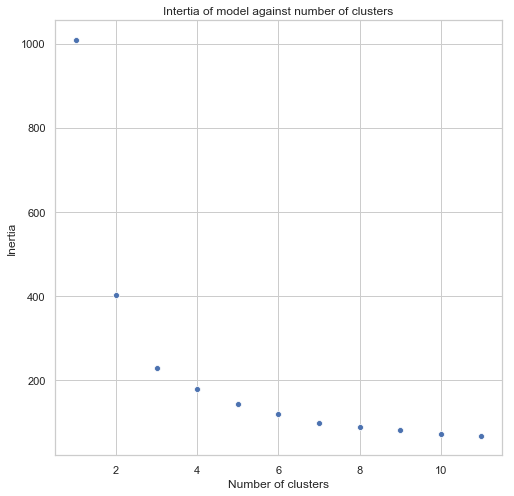

In [175]:
from sklearn.cluster import KMeans

y= []

for n in range(1,12):
    #calculate and plot the inertia with an increasing number of clusters
    model= KMeans(n_clusters=n, random_state=42)
    x = model.fit(scaled_features)
    y.append(x.inertia_)
    
fig, ax = plt.subplots(1,1, figsize=(8,8))
sns.scatterplot(x=range(1,len(y)+1), y=y)
plt.title('Intertia of model against number of clusters')
plt.ylabel('Inertia')
plt.xlabel('Number of clusters')
plt.show()

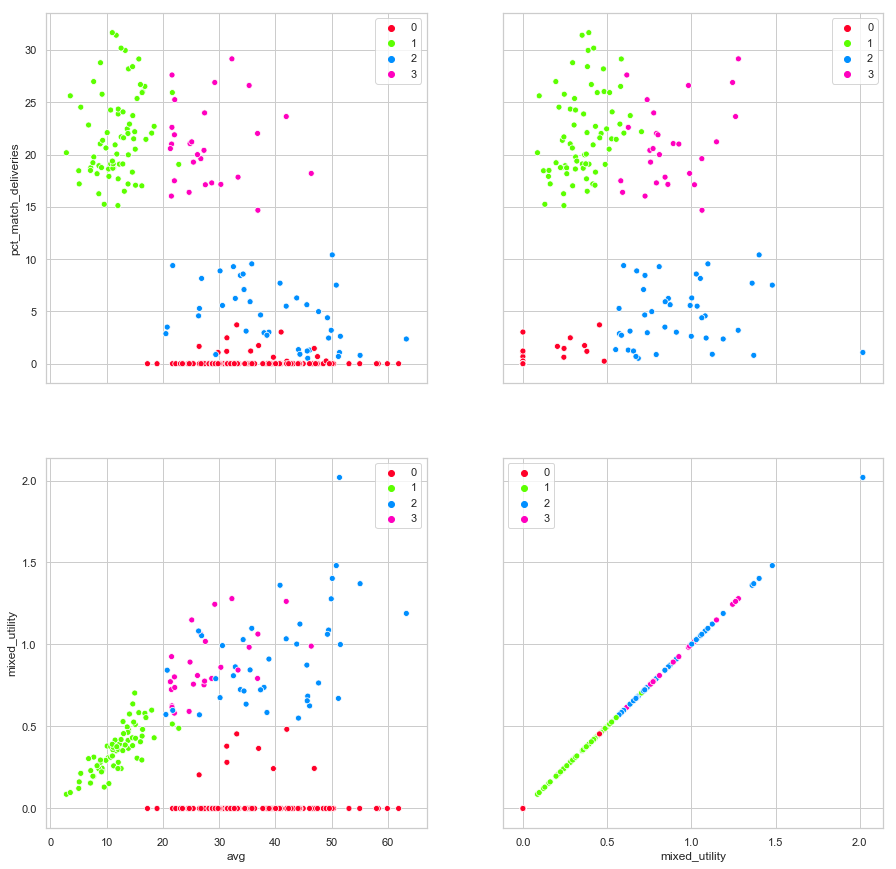

In [176]:
## In the figure above it is not entirely clear what the optimal number of clusters is. 
## Using knowledge of the dataset we can reasonably expect that there will be at least 4 clusters
## Batsman, Bowler, Batting allrounder and Bowling allrounder


#note we can experiment by changing the number of clusters
model= KMeans(n_clusters=4, random_state=42)
x = model.fit(scaled_features)
kmeans_labels = x.labels_

#colour labels and plot against features

fig, ax = plt.subplots(2,2, figsize=(15,15),sharey='row',sharex='col')

#plot percent of match deliveries against batting average
sns.scatterplot(x=features['avg'], y=features['pct_match_deliveries'], hue=kmeans_labels, ax=ax[0,0], legend='full', palette='gist_rainbow')

#plot percent of match deliveries against mixed utility
sns.scatterplot(x=features['mixed_utility'], y=features['pct_match_deliveries'], hue=kmeans_labels, ax=ax[0,1], legend='full', palette='gist_rainbow')

#plot mixed utility against batting average
sns.scatterplot(x=features['avg'], y=features['mixed_utility'], hue=kmeans_labels, ax=ax[1,0], legend='full', palette='gist_rainbow')


#plot mixed utility against itself
sns.scatterplot(x=features['mixed_utility'], y=features['mixed_utility'], hue=kmeans_labels, ax=ax[1,1], legend='full', palette='gist_rainbow')


plt.show()


#### Remarks

It appears that there are four clear clusters within our data. If we use 4 clusters, then the figures above seem to indicate that these correspond to:

    0. high percentage match deliveries, low batting average:         Bowler
    1. low percentage match deliveries, high batting average:         Batsman
    2. moderate percentage match deliveries, high batting average:    Batting allrounder
    3. high percentage of match deliveries, moderate batting average: Bowling allrounder
    
In terms of their mixed utility both allrounder classes seem to share a similar distribution of scores, and be placed higher than the mixed utility of both bowlers and batsmen. This justifies this metric being used to identify allround performances.

### 3.2 TSNE Dimension reduction

Sometimes it is useful to represent higher dimensional distributions in two dimensions. TSNE is a manifold process which attempts to flatten higher dimensional features into two dimensions while maintaining the relative 'closeness' of certain datapoints. Distances between points are not preserved and this should be used as an illustration only.

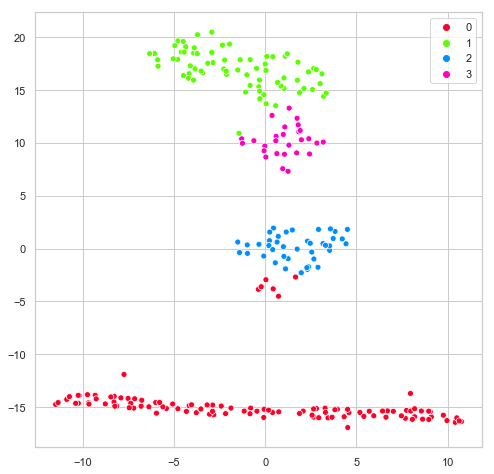

In [177]:
from sklearn.manifold import TSNE

#instantiate a model
m = TSNE(learning_rate=50, random_state=42)

tsne_features = m.fit_transform(scaled_features)

#plot the resulting 2D representation 

fig, ax = plt.subplots(1,1, figsize=(8,8))
sns.scatterplot(x=tsne_features[:,0], y=tsne_features[:,1], hue=x.labels_, palette='gist_rainbow', legend='full')
plt.show()

#### Remarks

The 2D representation of the data seems to show that batsmen are more distantly removed from the other three classes. This makes some intuitive sense since all roles bat, but batsmen do not (typically) bowl. 

Closest to the batsman group are batting allrounders, then bowling allrounders, and finally bowlers. Again this order makes sense in terms of the players respective roles.

Finally I note that there appear to be a few batsmen who are clustered near the batting allrounders. These are likely to correspond with the batsmen in the previous section who had mixed utilities between 0.3 and 0.5 - placeing them above other batsmen, but below allrounders. This is most clear in the mixed ultility vs batting average plot.

### 3.3 Hierarchical Clustering

Hierarchical clustering is a type of clustering method which works by ....

Player labels and counts
Counter({4: 112, 2: 71, 3: 42, 1: 27})
1: Batsmen, 2:Bowlers, 3: Bowling allrounders, 4:Batting allrounders


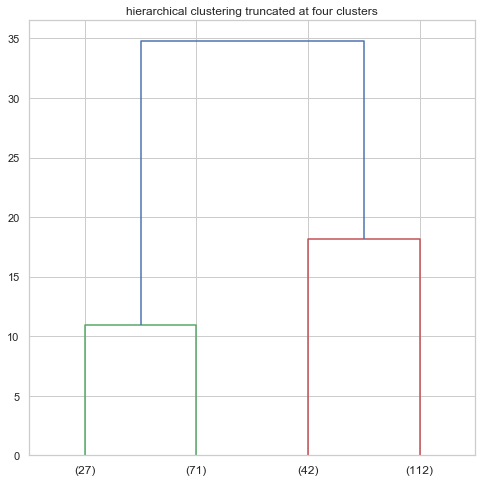

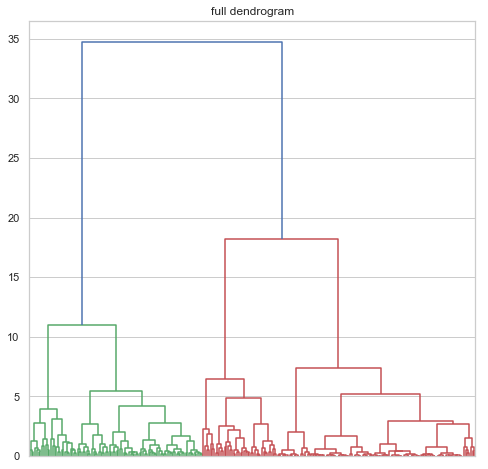

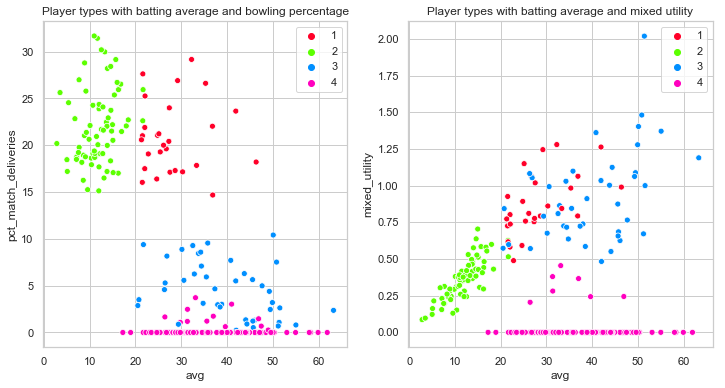

In [179]:
#import linkage and dendrogram

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

Z = linkage(scaled_features, method='ward', metric='euclidean')
#labels truncating at four clusters
labels = fcluster(Z, t=4, criterion='maxclust')

#count number of labels generated
import collections
counts = collections.Counter(labels)
print('Player labels and counts')
print(counts)
print('1: Batsmen, 2:Bowlers, 3: Bowling allrounders, 4:Batting allrounders')


#plot the resulting truncated dedrogram
fig, ax = plt.subplots(1,1, figsize=(8,8))
dn = dendrogram(Z, labels=labels, truncate_mode='lastp', p=4)
plt.title('hierarchical clustering truncated at four clusters')
plt.show()

#plot the full dendrogram
fig_0, ax_0 = plt.subplots(1,1, figsize=(8,8))
dn = dendrogram(Z, labels=labels, no_labels=True)
plt.title('full dendrogram')
plt.show()


## plot certain features against labels
fig_1, ax_1 = plt.subplots(1,2, figsize=(12,6))
sns.scatterplot(x=features['avg'], y=features['pct_match_deliveries'], hue=labels, ax=ax_1[0], legend='full', palette='gist_rainbow')
ax_1[0].set_title('Player types with batting average and bowling percentage')

sns.scatterplot(x=features['avg'], y=features['mixed_utility'], hue=labels, ax=ax_1[1], legend='full', palette='gist_rainbow')
ax_1[1].set_title('Player types with batting average and mixed utility')
plt.show()


#### Remarks

Similar results to Kmeans are achieved using hierarchical clustering. An additional benefit of the hierarchical clustering is that it gives the 'closeness' of each cluster which is represented by the y axis. 

The first split is between batsmen and all other players. This is intuitive because batsmen (rarely) bowl, but bowlers and allrounders both bat and bowl making them more similar. This result can also be seen in the relative closeness of the groups in the 2D TSNE representation in the previous subsection.

The next split removes bowlers from the remaining players. While batting allrounders may seem the next most removed group in a percentage of match deliveries vs batting average plot, a plot of mixed utility vs batting average shows that bowlers are distinct group.

The third split distinguishes between batting and bowling allrounders.

## 4. Samples of Australian Players

In this section I will generate samples of Australian players which fall into these four categories. This serves merely to verify that the labelling process is correct, and I use Australia as a country whose players I am most familiar with. Note that this can be changed to other countries in the code below.

In [180]:
player_subset['player_class'] = kmeans_labels

print('Examples of Australian players within each class')

x = player_subset.loc[(player_subset['team']=='Australia') & (player_subset['player_class']==0),['player','player_class','avg','pct_match_deliveries','mixed_utility']]
print('Bowlers')
display(x.head())

x = player_subset.loc[(player_subset['team']=='Australia') & (player_subset['player_class']==1),['player','player_class','avg','pct_match_deliveries','mixed_utility']]
print('Batsmen')
display(x.head())

x = player_subset.loc[(player_subset['team']=='Australia') & (player_subset['player_class']==2),['player','player_class','avg','pct_match_deliveries','mixed_utility']]
print('Batting Allrounders')
display(x.head())

x = player_subset.loc[(player_subset['team']=='Australia') & (player_subset['player_class']==3),['player','player_class','avg','pct_match_deliveries','mixed_utility']]
print('Bowling Allrounders')
display(x.head())


Examples of Australian players within each class
Bowlers


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,player,player_class,avg,pct_match_deliveries,mixed_utility
18,AC Voges,0,61.875000,0.0,0.0
60,BJ Haddin,0,32.989899,0.0,0.0
87,CJL Rogers,0,41.979167,0.0,0.0
131,EJM Cowan,0,31.281250,0.0,0.0
200,JA Burns,0,37.956522,0.0,0.0


Batsmen


,player,player_class,avg,pct_match_deliveries,mixed_utility
51,B Lee,1,18.000000,22.058644,0.599655
69,BW Hilfenhaus,1,13.653846,22.463610,0.497143
110,DE Bollinger,1,7.714286,19.776149,0.313080
235,JR Hazlewood,1,14.052632,22.922522,0.576000
375,NM Lyon,1,12.051724,23.888849,0.360456


Batting Allrounders


,player,player_class,avg,pct_match_deliveries,mixed_utility
11,A Symonds,2,50.800000,7.517405,1.481050
105,DA Warner,2,45.727273,0.520975,0.685053
303,MEK Hussey,2,44.340206,0.903311,1.124570
307,MJ Clarke,2,49.434783,2.456156,1.088038
312,MJ North,2,35.484848,5.930490,0.844877


Bowling Allrounders


,player,player_class,avg,pct_match_deliveries,mixed_utility
224,JL Pattinson,3,26.733333,19.613375,1.062533
293,MA Starc,3,24.813953,21.058610,0.892675
305,MG Johnson,3,22.043011,21.895420,0.802186
374,NM Hauritz,3,27.400000,23.990387,0.776735
429,RJ Harris,3,21.535714,21.011404,0.926003


### Remarks

The players above all seem to conform to their expected labels. Note that the classifications take into account data across each players career. For example Brett Lee was regarded as a bowling allrounder in his later career, having improved his batting performance, but here is classified only as a bowler. His batting average is still relatively high compared to the other bowlers sampled, and this is a reflection of his fair batting capacity.

## 5. Principle Component Analysis

The previous part of the project proceeded using intuition about cricket players to try and determine which features were likely to contribute to the classification of players. For example choosing the average number of runs scored is a critical factor for batsmen.

Principle component analysis (PCA) is a method by which a large number of features can be condensed into fewer features via linear transformations. Theese principle components are able to explain the majority of variance within the data. This has two benifits. The first is that machine learning on fewer features is faster and less likely to overfit on irrelevant factors. The second is that important factors are not overlooked, and are chosen systematically. 

In this section I repeat section 3.1, producing a Kmeans clustering using principle components rather than hand chosen features.

In [182]:
#perform principle component analysis

full_features = player_subset[['avg','pct_match_deliveries','wkt_per_run','wkt_per_ball','mixed_utility']]
full_features = player_subset[['avg','mixed_utility','wicket_rate','pct_match_deliveries']]

scaled_full_features = StandardScaler().fit_transform(full_features)

from sklearn.decomposition import PCA

#choose number of principle components to use
n_components = 2
pca = PCA(n_components = n_components)
principle_components = pca.fit_transform(scaled_full_features)

print('{}% variance explained by {} components'.format(100*np.sum(pca.explained_variance_ratio_), n_components))


principle_df = pd.DataFrame(data = principle_components)

print('The principle component matrix is:')
print(pca.components_)


94.07911356381% variance explained by 2 components
The principle component matrix is:
[[-0.47618495  0.26634662  0.591971    0.59319281]
 [ 0.51577471  0.85645734  0.0180408   0.01148026]]


The first principle component has a strong correlation with batting average and a strong negative correlation with the percentage of match deliveries bowled. The second principle component is also strongly correlated with batting average and is also strongly correlatted with the percentage of match deliveries bowled.

The first principle component is strongly correlated with wicket rate and the percentage of match deliveries, and strongly anti correlated with batting average. 

The second principle component is correlated with batting average and and mixed utility.

The first component can be interpreted as a 'batting/bowling' axis.
    (small values) Batsman <----------> Bowler (high values)
    
The second component can be interpreted as an 'allrounder' axis.
    (small values) Specialist <---------> Allrounder (high values)
    


### 5.1 Clustering using principle components

In this section I will repeat some of the clustering (using the same Kmeans classifier) in section 3. Instead of using features directly I will use principle components.

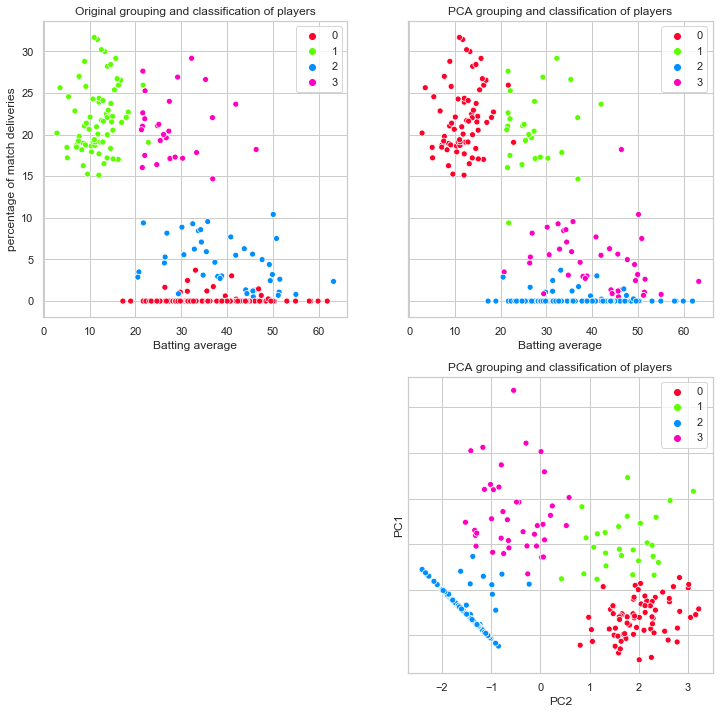

In [184]:
#note we can experiment by changing the number of clusters
model= KMeans(n_clusters=4, random_state=42)
x = model.fit(principle_components)
kmeans_labels2 = x.labels_



#colour labels and plot against features

fig, ax = plt.subplots(2,2, figsize=(12,12),sharey='row')

#pct match_deliveries against average
sns.scatterplot(x=features['avg'], y=features['pct_match_deliveries'], hue=kmeans_labels2, ax=ax[0,1], legend='full', palette='gist_rainbow')
ax[0,1].set_title('PCA grouping and classification of players')
ax[0,1].set_ylabel('percentage of match deliveries')
ax[0,1].set_xlabel('Batting average')

#plot percent of match deliveries against batting average
sns.scatterplot(x=principle_components[:,0], y=principle_components[:,1], hue=kmeans_labels2, ax=ax[1,1], legend='full', palette='gist_rainbow')
ax[1,1].set_title('PCA grouping and classification of players')
ax[1,1].set_ylabel('PC1')
ax[1,1].set_xlabel('PC2')

#the original scatterplot
sns.scatterplot(x=features['avg'], y=features['pct_match_deliveries'], hue=kmeans_labels, ax=ax[0,0], legend='full', palette='gist_rainbow')
ax[0,0].set_title('Original grouping and classification of players')
ax[0,0].set_ylabel('percentage of match deliveries')
ax[0,0].set_xlabel('Batting average')

ax[1,0].axis('off')

plt.show()





#### Remarks

From this plot it appears that the labeling is:
    0: Bowler
    1: Bowling Allrounder
    2: Batsman
    3: Batting Allrounder

The clustering using 2 principle components from a PCA analysis appears to be nearly identical with the clustering achieved using the full four components in section 3. While the PCA analysis here does not seem to produce better results, it does produce comparable results with a decrease in complexity. For a larger dataset with hundreds of features PCA is useful for reducing complexity down into a much smaller number of principle components.

### 5.2 Heirarchy classification using principle components

This section will generate classification dendrograms using principle components rather than features directly.

Player labels and counts
Counter({3: 112, 2: 71, 4: 44, 1: 25})
1: Bowlers, 2:Batting allrounders, 3: Bowling allrounders, 4:Batsmen


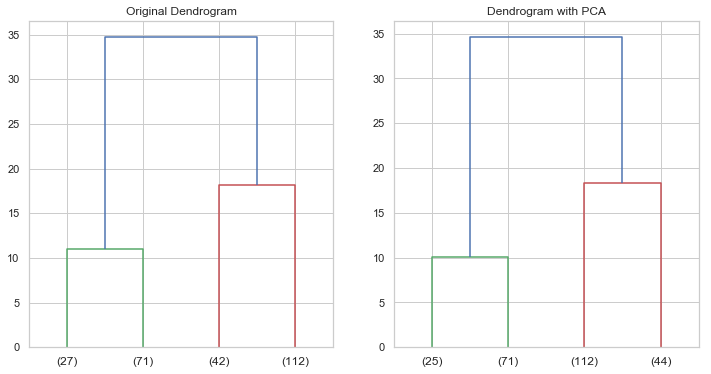

In [185]:
##from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

Z_2 = linkage(principle_components, method='ward', metric='euclidean')
#labels truncating at four clusters
labels_2 = fcluster(Z_2, t=4, criterion='maxclust')

#count number of labels generated
##import collections
counts = collections.Counter(labels_2)
print('Player labels and counts')
print(counts)
print('1: Bowlers, 2:Batting allrounders, 3: Bowling allrounders, 4:Batsmen')


#plot the resulting truncated dedrogram
fig, ax = plt.subplots(1,2, figsize=(12,6))

dn = dendrogram(Z, labels=labels, truncate_mode='lastp', p=4, ax=ax[0])
ax[0].set_title('Original Dendrogram')

dn = dendrogram(Z_2, labels=labels_2, truncate_mode='lastp', p=4, ax=ax[1])
ax[1].set_title('Dendrogram with PCA')
plt.show()

### Remarks

The heirarchical clustering of the data is very similar between features and principle components. There appear to be only a few changes in the classiciation (2 fewer bowling allrounders, 2 more batting allrounders). 

## 5. Final Remarks and Summary

Using Kmeans clustering I have shown that there are four main classes of cricket player. These are batsmen, batting allrounders, bowling allrounders and bowlers. Of course there are more classes than just this. Within bowlers there are pace bowlers and spin bowlers, and the wicket keeper is a specialist fielding position. The dataset does not provide information about fielding performance, so wicket keepers could not be classified. Classifying different bowlers may be possible, but was not attempted here.




-- note that a 5 group split results in the batsmen being split by those who are part time bowlers and those who are not. That the batsmen are the next group that is split can be seen by the height of the junction in the dendrogram. Further splittings occur rapidly from that point onward and likely do not signify particularly meaningful trends in the data.